# Code for writing the lung sound data to .ts file

Below are different approaches to loading the data to a .ts file, so that it can be utilised by sktime

In [10]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src')

import utility

import librosa
import sktime
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.model_selection import train_test_split

from math import ceil

def znorm(timeseries):
    mean = np.mean(timeseries)
    sd = np.std(timeseries)
    return (timeseries - mean)/sd

target_rate = 44100
ds_target_rate = 4000
AUTH = 'Litt3200'
ESSUA = ['AKGC417L', 'LittC2SE', 'Meditron']

Firstly printing some information to get an understanding of what data is present

In [11]:
none_path = module_path + '/data/crackleWheeze/none/'
crackle_path = module_path + '/data/crackleWheeze/crackle/'
both_path = module_path + '/data/crackleWheeze/both/'
wheeze_path = module_path + '/data/crackleWheeze/wheeze/'


none = [file_name for file_name in os.listdir(none_path) if '.wav' in file_name]
crackle = [file_name for file_name in os.listdir(crackle_path) if '.wav' in file_name]
wheeze = [file_name for file_name in os.listdir(wheeze_path) if '.wav' in file_name]
both= [file_name for file_name in os.listdir(both_path) if '.wav' in file_name]
print(f'Number of crackle files available: {len(crackle)}',
      f'\nNumber of wheeze files available: {len(wheeze)}',
      f'\nNumber of none files available {len(none)}', 
      f' \nNumber of both files available {len(both)}')

class_lists = {'crackle' : crackle,
    'wheeze': wheeze,
    'none': none, 
    'both': both
}

class_paths = {'crackle' : crackle_path,
    'wheeze': wheeze_path,
    'none': none_path, 
    'both': both_path
}

frame_len = round(ds_target_rate*0.002)
print(f'Frame length for calculating rmf: {frame_len}')
hop_len = ceil(frame_len/1.5)
print(f'Hop length for calculating rmf: {hop_len}')

Number of crackle files available: 1864 
Number of wheeze files available: 886 
Number of none files available 3642  
Number of both files available 506
Frame length for calculating rmf: 8
Hop length for calculating rmf: 6


# Zero padding to get equal lengths

AKGC417L


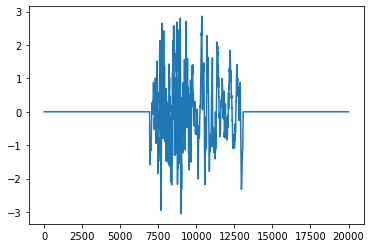

In [7]:
class_list =  ['crackle', 'wheeze', 'none', 'both']
count = 0
import matplotlib.pyplot as plt
for class_ in class_list:
    for name in class_lists[class_]: 
        rec_met = name[14:22]
        print(rec_met)
        if rec_met == AUTH:
            count = count + 1
        audio_file = class_paths[class_] + name
        sr, audio = utility.read_wav_file(audio_file, target_rate)
        audio = utility.denoise_audio(audio)
        audio, sr = utility.downsample(audio, sr, 4000)
        audio = znorm(audio)
        audio = zero_pad(audio, 20000)
        plt.plot(audio)
        break
    break
        


# Creating the .ts file for the four class classification problem

classes: 
   0: crackle
   1: wheeze
   2: none 
   3: both
   
Below the rms of frames are calculated, to compress the data. 

In [160]:
def write_class(writer, class_list, class_name, class_path, fixed= True, fixed_len = 2000):
    classes = {
    'crackle': '0',
    'wheeze': '1',
    'none': '2',
    'both': '3'
    }
    for name in class_list: 
        audio_file = class_path + name
        sr, audio = utility.read_wav_file(audio_file, target_rate)
        audio = utility.denoise_audio(audio)
        audio, sr = utility.downsample(audio, sr, 4000)
        audio = znorm(audio)
        rms_new = librosa.feature.rms(audio, frame_length = frame_len, hop_length = hop_len)[0]
        
        if fixed: 
            if len(rms_new) > fixed_len:
                    rms_new = rms_new[0:fixed_len]
            df_new = np.zeros(fixed_len)
            df_new[0:len(rms_new)] = rms_new
            new_row = str(list(df_new))[1:-1].replace(' ', '') + ':' + classes[class_name] + '\n'
        else: 
            new_row = str(list(rms_new))[1:-1].replace(' ', '') + ':' + classes[class_name] + '\n'
        writer.write(new_row)

def write_ts(filename, fixed = True, fixed_len = 2000):
    w = open(filename, 'w+')
    row = w.read()

    w.write('@problemName LungSounds \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    if fixed: 
        w.write('@equalLength true \n')
        w.write(f'@seriesLength {str(fixed_len)} \n')
    else:
        w.write('@equalLength false \n')
    w.write('@classLabel true crackle wheeze none both \n')
    w.write('@data \n')

    for class_name, class_list in class_lists.items():
        if fixed:
            write_class(w , class_list, class_name, class_paths[class_name], True, fixed_len)
        else: 
            write_class(w , class_list, class_name, class_paths[class_name], False)
    #os.close()

In [161]:
#write_ts(module_path + '/data/ts_files/crackleWheeze.ts', False)

# Creating the .ts files for the two class classification problem
Below the rms of frames are calculated, to compress the data. 

In [11]:
def write_class2(writer, class_list, class_name, class_path, fixed= True, fixed_len = 2000):
    classes = {
    'crackle': '1',
    'wheeze': '0',
    'none': '0',
    'both': '1'
    }
    for name in class_list: 
        audio_file = class_path + name
        sr, audio = utility.read_wav_file(audio_file, target_rate)
        audio = utility.denoise_audio(audio)
        audio, sr = utility.downsample(audio, sr, 4000)
        audio = znorm(audio)
        rms_new = librosa.feature.rms(audio, frame_length = frame_len, hop_length = hop_len)[0]
        
        if fixed: 
            if len(rms_new) > fixed_len:
                    rms_new = rms_new[0:fixed_len]
            df_new = np.zeros(fixed_len)
            df_new[0:len(rms_new)] = rms_new
            new_row = str(list(df_new))[1:-1].replace(' ', '') + ':' + classes[class_name] + '\n'
        else: 
            new_row = str(list(rms_new))[1:-1].replace(' ', '') + ':' + classes[class_name] + '\n'
        writer.write(new_row)

def write_ts2(filename, fixed = True, fixed_len = 2000):
    w = open(filename, 'w+')
    row = w.read()

    w.write('@problemName LungSounds \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    if fixed: 
        w.write('@equalLength true \n')
        w.write(f'@seriesLength {str(fixed_len)} \n')
    else:
        w.write('@equalLength false \n')
    w.write('@classLabel true crackle no_crackle \n')
    w.write('@data \n')

    for class_name, class_list in class_lists.items():
        if fixed:
            write_class2(w , class_list, class_name, class_paths[class_name], True, fixed_len)
        else: 
            write_class2(w , class_list, class_name, class_paths[class_name], False)
    #os.close()

In [12]:
write_ts2(module_path + '/data/ts_files/crackleNoCrackleSamleLength3000.ts', True, 3000)

# Creating the .ts file based on the entire timeseries (no rms compression)

Below the entire timeseries is written to the .ts file. The timeseries that are longer than 5 seconds are discarded to begin with. 
Zero padding is utilised to make catch22 happy

In [12]:
def zero_pad(ts, fixed_len):
    df_new = np.zeros(fixed_len)
    len_ts = len(ts)
    pad = (fixed_len - len_ts)//2
    df_new[pad:pad + len_ts] = ts
    return df_new



def write_class2(writer, class_list, class_name, class_path, fixed_len = 20000):
    classes = {
    'crackle': '1',
    'wheeze': '0',
    'none': '0',
    'both': '1'
    }
    for name in class_list: 
        audio_file = class_path + name
        sr, audio = utility.read_wav_file(audio_file, target_rate)
        audio = utility.denoise_audio(audio)
        audio, sr = utility.downsample(audio, sr, 4000)
        #audio = znorm(audio)
        if len(audio) > fixed_len:
                continue
        else: 
            df_new = zero_pad(audio, fixed_len)
            new_row = str(list(df_new))[1:-1].replace(' ', '') + ':' + classes[class_name] + '\n'
            writer.write(new_row)

def write_ts2(filename, fixed_len = 20000):
    w = open(filename, 'w+')
    row = w.read()

    w.write('@problemName LungSounds \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    w.write('@equalLength true \n')
    w.write(f'@seriesLength {str(fixed_len)} \n')
    w.write('@classLabel true no_crackle crackle\n')
    w.write('@data \n')

    for class_name, class_list in class_lists.items():
        write_class2(w , class_list, class_name, class_paths[class_name])

In [13]:
write_ts2(module_path + '/data/ts_files/crackleNoCrackle_no_rms.ts', fixed_len = 20000)

No zero-padding inequal length 

In [9]:
def write_class2(writer, class_list, class_name, class_path):
    classes = {
    'crackle': '1',
    'wheeze': '0',
    'none': '0',
    'both': '1'
    }
    for name in class_list: 
        audio_file = class_path + name
        sr, audio = utility.read_wav_file(audio_file, target_rate)
        audio = utility.denoise_audio(audio)
        audio, sr = utility.downsample(audio, sr, 4000)
    
        #df_new = zero_pad(audio, fixed_len)
        new_row = str(list(audio))[1:-1].replace(' ', '') + ':' + classes[class_name] + '\n'
        writer.write(new_row)

def write_ts2(filename):
    w = open(filename, 'w+')
    row = w.read()

    w.write('@problemName LungSounds \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    w.write('@equalLength false \n')
    w.write('@classLabel true no_crackle crackle\n')
    w.write('@data \n')

    for class_name, class_list in class_lists.items():
        write_class2(w , class_list, class_name, class_paths[class_name])
        
write_ts2(module_path + '/data/ts_files/crackleNoCrackle_FULL.ts')

# Creating .ts file for two class problem

with seperate train and test set based on the recording institution

Below the rms of frames are calculated, to compress the data. 

In [8]:
AUTH = 'Litt3200'
ESSUA = ['AKGC417L', 'LittC2SE', 'Meditron']

def write_class_separate_loc(writer, class_list, class_name, class_path, fixed= True, fixed_len = 2000):
    classes = {
    'crackle': '1',
    'wheeze': '0',
    'none': '0',
    'both': '1'
    }
    for name in class_list: 
        rec_met = name[14:22]
        if rec_met == AUTH:
            audio_file = class_path + name
            sr, audio = utility.read_wav_file(audio_file, target_rate)
            audio = utility.denoise_audio(audio)
            audio, sr = utility.downsample(audio, sr, 4000)
            audio = znorm(audio)
            rms_new = librosa.feature.rms(audio, frame_length = frame_len, hop_length = hop_len)[0]

            if fixed: 
                if len(rms_new) > fixed_len:
                        rms_new = rms_new[0:fixed_len]
                df_new = np.zeros(fixed_len)
                df_new[0:len(rms_new)] = rms_new
                new_row = str(list(df_new))[1:-1].replace(' ', '') + ':' + classes[class_name] + '\n'
            else: 
                new_row = str(list(rms_new))[1:-1].replace(' ', '') + ':' + classes[class_name] + '\n'
            writer.write(new_row)

def write_ts_separate_loc(filename, fixed = True, fixed_len = 2000):
    w = open(filename, 'w+')
    row = w.read()

    w.write('@problemName LungSounds \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    if fixed: 
        w.write('@equalLength true \n')
        w.write(f'@seriesLength {str(fixed_len)} \n')
    else:
        w.write('@equalLength false \n')
    w.write('@classLabel true crackle no_crackle \n')
    w.write('@data \n')

    for class_name, class_list in class_lists.items():
        if fixed:
            write_class2(w , class_list, class_name, class_paths[class_name], True, fixed_len)
        else: 
            write_class2(w , class_list, class_name, class_paths[class_name], False)
    #os.close()
    
write_ts_separate_loc(module_path + '/data/ts_files/crackleNoCrackle_3000_same_AUTH.ts', True, 3000)